<a href="https://colab.research.google.com/github/vivekp12/dst-group-project-2/blob/main/VivekP/ForConsistency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[Investigation of Tanh activation function](#scrollTo=Db4dvLsLU0UY)

>[Data Augmentation](#scrollTo=Db4dvLsLU0UY)

>[Creating training and testing data set for loading and preprocessing the images](#scrollTo=ZP8zGYwkUv6z)

>[Building and training the model](#scrollTo=hrWYKmiEVr4S)

>[Evalutating the model on test data](#scrollTo=dQ9sN6o4fVEc)

>[Plot training history](#scrollTo=Uu83BmTBftLA)






# Investigation of Tanh activation function

...

# 1. Data Augmentation   

...

In [1]:
from pathlib import Path  # Import pathlib to work with paths
import kagglehub
import os  # Import os module for file operations
import hashlib
import numpy as np
from tqdm import tqdm
import cv2
import os
import imutils

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

# Convert path to a Path object
path = Path(path)

# Define your project directory and labels based on your dataset structure
PROJECT_DIR = path
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']  # Adjust these labels based on your dataset's folder names

def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img


# Convert 'path' to Path object (already done above)
train_dir = path / "Training"
test_dir = path / "Testing"

if __name__ == "__main__":
    training = train_dir
    testing = test_dir

    training_dir = os.listdir(training)
    testing_dir = os.listdir(testing)

    IMG_SIZE = 256

    for dir in training_dir:
        save_path = Path('cleaned/Training') / dir  # Using pathlib's '/' operator
        path = training / dir  # Using pathlib's '/' operator
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))  # Convert Path to string for OpenCV
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)  # Convert Path to string for OpenCV

    for dir in testing_dir:
        save_path = Path('cleaned/Testing') / dir
        path = testing / dir
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)


100%|██████████| 149M/149M [00:07<00:00, 20.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


# 2. Creating training and testing data set for loading and preprocessing the images   


In this section we aim to use the function __ImageDataGenerator()__ as a means to preprocess the images in both the training and testing folders of the Brain MRI folder. This is done to create changes to images that promotes randomness and allows the model to generalise better on the available data and also on unseen data while testing.

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from pathlib import Path
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import classification_report, confusion_matrix

# Define directories for training and testing images
train_dir = Path('cleaned/Training')
test_dir = Path('cleaned/Testing')

# Number of classes
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Image size and batch size
IMG_SIZE = 64  # Resize images to 64x64
BATCH_SIZE = 32

# Setup ImageDataGenerators for loading and preprocessing the images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in and out
    horizontal_flip=True,  # Flip horizontally
    fill_mode='nearest',  # Fill any missing pixels using the nearest pixel
    brightness_range=(0.5, 1.5),  # Randomly adjust brightness between 0.5 and 1.5 times the original
    channel_shift_range=20.0  # Randomly shift RGB channels (intensity)
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for test data

# Load images from directories using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # For multi-class classification
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for test data
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# 3. Building and training the model   
We use __Convlolution Neural Networks(CNN)__ with the __Tanh activation function__ on multiple input layers and __softmax__ function on the output layer for 4 classes. Model compiling takes place with the __Adam__ optimiser using the loss function as __categorical_crossentropy__ for a multi-class classificaton model consisting of mutliple output layers.

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Build an optimized CNN model
model = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='tanh', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(256, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(512, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='tanh'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(128, activation='tanh'),
    Dropout(0.5),  # Adding another dropout layer

    Dense(4, activation='softmax')  # Output layer for 4 classes
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=100,  # Increased epochs to get better training results
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)

Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.3110 - loss: 1.8102 - val_accuracy: 0.3187 - val_loss: 1.3904
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3438 - loss: 1.4751

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3438 - loss: 1.4751 - val_accuracy: 0.0000e+00 - val_loss: 1.7949
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 32s 95ms/step - accuracy: 0.3932 - loss: 1.4223 - val_accuracy: 0.4977 - val_loss: 1.1163
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.5000 - loss: 1.2134 - val_accuracy: 0.1613 - val_loss: 1.6232
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.4723 - loss: 1.2093 - val_accuracy: 0.6117 - val_loss: 0.9712
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 122us/step - accuracy: 0.5938 - loss: 0.8658 - val_accuracy: 0.8387 - val_loss: 0.6923
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.5717 - loss: 1.0290 - val_accuracy: 0.6875 - val_loss: 0.7963
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.5938 - loss: 0.7309 - val_accuracy: 0.9355 - val_loss: 0.3200
Epoch 9/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.6359 - loss: 0.8938 - va

# 4. Evalutating the model on test data   
The test and train accuracy and loss are calucalted to inference on the capability of the neural network model on the given set of images.


In [ ]:
train_score = model.evaluate(train_generator)
test_score = model.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.7283 - loss: 0.8563
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7517 - loss: 0.6327
Train Loss:  0.8542219996452332
Train Accuracy:  0.7277660965919495
--------------------
--------------------
Test Loss:  0.5072875618934631
Test Accuracy:  0.816170871257782


# 5. Plot training history


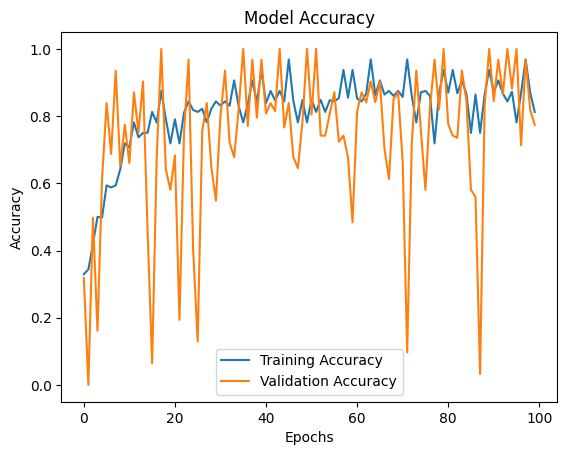

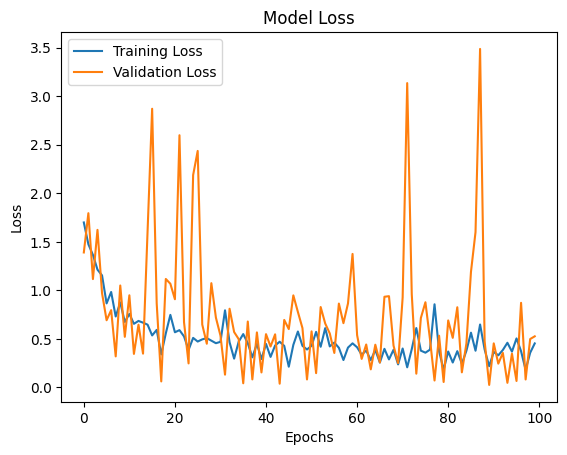

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
The predicted label is: meningioma
Prediction score for meningioma: 0.72


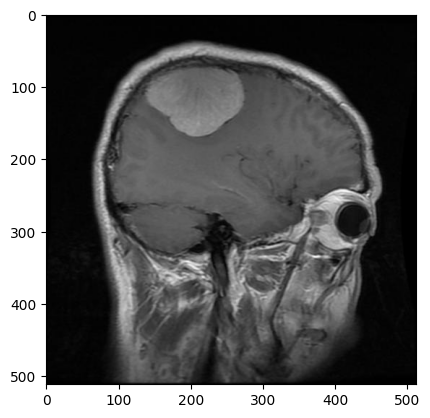

In [ ]:
from tensorflow import keras

from tensorflow.keras.preprocessing import image

def predict_image(model, img_path, target_size=(64, 64)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize as trained

    prediction = model.predict(img_array)
    class_index = np.argmax(prediction, axis=1)[0]
    class_label = list(train_generator.class_indices.keys())[class_index]
    prediction_score = prediction[0][class_index]

    return class_label, prediction_score

# Predict a new image
img_path = keras.utils.load_img('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/meningioma/Te-me_0282.jpg')
plt.imshow(img_path)
img = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/meningioma/Te-me_0282.jpg'
predicted_label, prediction_score = predict_image(model, img)
print(f"The predicted label is: {predicted_label}")
print(f"Prediction score for {predicted_label}: {prediction_score:.2f}")

Model with Early stopping tuning monitoring validation loss to get the optimal epoch

In [53]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Build an optimized CNN model
model_early = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='tanh', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(256, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(512, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='tanh'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(128, activation='tanh'),
    Dropout(0.5),  # Adding another dropout layer

    Dense(4, activation='softmax')  # Output layer for 4 classes
])

model_early.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Print a message when training is stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

In [55]:
history_early = model_early.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=100,  # Increased epochs to get better training results
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
    ,callbacks=[early_stopping])

Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - accuracy: 0.3224 - loss: 1.8025 - val_accuracy: 0.2828 - val_loss: 1.3524
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.1562 - loss: 2.0067

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1562 - loss: 2.0067 - val_accuracy: 0.0323 - val_loss: 1.9968
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.3787 - loss: 1.4762 - val_accuracy: 0.3078 - val_loss: 1.4969
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 126us/step - accuracy: 0.5000 - loss: 1.3151 - val_accuracy: 0.0000e+00 - val_loss: 1.7969
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.4500 - loss: 1.2705 - val_accuracy: 0.5359 - val_loss: 1.0952
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 97us/step - accuracy: 0.5312 - loss: 1.2632 - val_accuracy: 0.1935 - val_loss: 1.4961
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.5422 - loss: 1.0535 - val_accuracy: 0.6469 - val_loss: 0.8921
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step - accuracy: 0.4375 - loss: 1.2031 - val_accuracy: 0.9032 - val_loss: 0.7024
Epoch 9/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.5958 - loss: 0.9547 - v

In [56]:
train_score = model_early.evaluate(train_generator)
test_score = model_early.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.8280 - loss: 0.4616
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7172 - loss: 0.7852
Train Loss:  0.46920454502105713
Train Accuracy:  0.8258053064346313
--------------------
--------------------
Test Loss:  0.5346214175224304
Test Accuracy:  0.8138825297355652


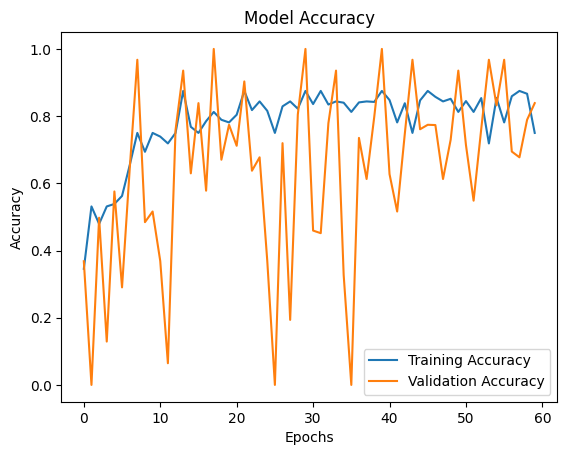

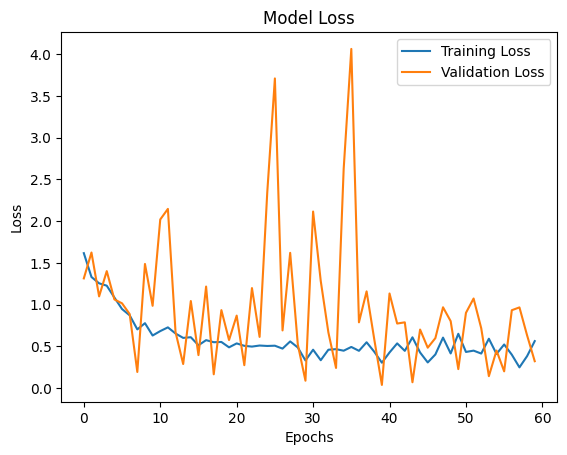

In [57]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
The predicted label is: meningioma
Prediction score for meningioma: 0.96


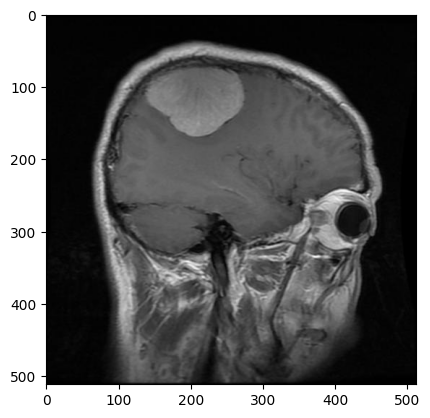

In [58]:
from tensorflow import keras

from tensorflow.keras.preprocessing import image

def predict_image(model, img_path, target_size=(64, 64)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize as trained

    prediction = model_early.predict(img_array)
    class_index = np.argmax(prediction, axis=1)[0]
    class_label = list(train_generator.class_indices.keys())[class_index]
    prediction_score = prediction[0][class_index]

    return class_label, prediction_score

# Predict a new image
img_path = keras.utils.load_img('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/meningioma/Te-me_0282.jpg')
plt.imshow(img_path)
img = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/meningioma/Te-me_0282.jpg'
predicted_label, prediction_score = predict_image(model, img)
print(f"The predicted label is: {predicted_label}")
print(f"Prediction score for {predicted_label}: {prediction_score:.2f}")

In [72]:
model_early.save('model_early.keras')

Model with learning rate tuning

In [77]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Build an optimized CNN model
model_reduce_lr = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='tanh', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(256, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(512, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='tanh'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(128, activation='tanh'),
    Dropout(0.5),  # Adding another dropout layer

    Dense(4, activation='softmax')  # Output layer for 4 classes
])

model_reduce_lr.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [78]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.2,  # Factor by which the learning rate will be reduced
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,  # Print messages when learning rate is reduced
    min_delta=0.0001, # Minimum change in the monitored quantity to qualify as an improvement.
    cooldown=0, # Number of epochs to wait before resuming normal operation after lr has been reduced.
    min_lr=0,  # Lower bound on the learning rate.
)

In [79]:
history_reduce_lr = model_reduce_lr.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=100,  # Increased epochs to get better training results
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
    ,callbacks=[early_stopping,reduce_lr])

Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - accuracy: 0.3087 - loss: 1.7764 - val_accuracy: 0.4523 - val_loss: 1.2294 - learning_rate: 0.0010
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.1562 - loss: 1.7865

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1562 - loss: 1.7865 - val_accuracy: 0.6129 - val_loss: 1.2301 - learning_rate: 0.0010
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 34s 100ms/step - accuracy: 0.3440 - loss: 1.5489 - val_accuracy: 0.5172 - val_loss: 1.0611 - learning_rate: 0.0010
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 137us/step - accuracy: 0.3125 - loss: 1.5550 - val_accuracy: 0.5806 - val_loss: 1.0805 - learning_rate: 0.0010
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.4107 - loss: 1.3294 - val_accuracy: 0.6211 - val_loss: 0.9210 - learning_rate: 0.0010
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 121us/step - accuracy: 0.3125 - loss: 1.3786 - val_accuracy: 0.2581 - val_loss: 1.1627 - learning_rate: 0.0010
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.5224 - loss: 1.0903 - val_accuracy: 0.6414 - val_loss: 0.8115 - learning_rate: 0.0010
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 130us/step - accuracy: 0.5625 - loss: 

In [80]:
train_score = model.evaluate(train_generator)
test_score = model.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.8074 - loss: 0.5010
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7201 - loss: 0.7418
Train Loss:  0.4950178861618042
Train Accuracy:  0.8128501176834106
--------------------
--------------------
Test Loss:  0.5344766974449158
Test Accuracy:  0.8115941882133484


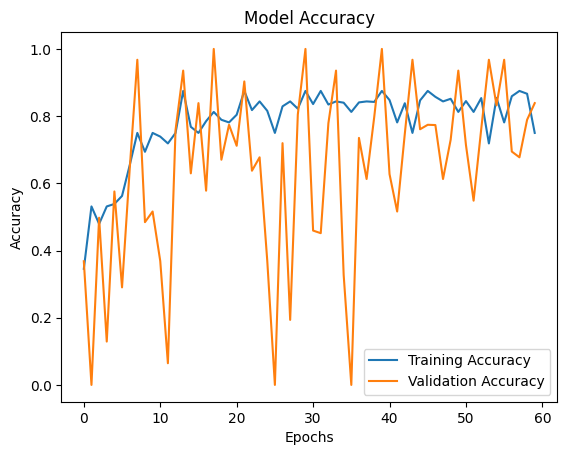

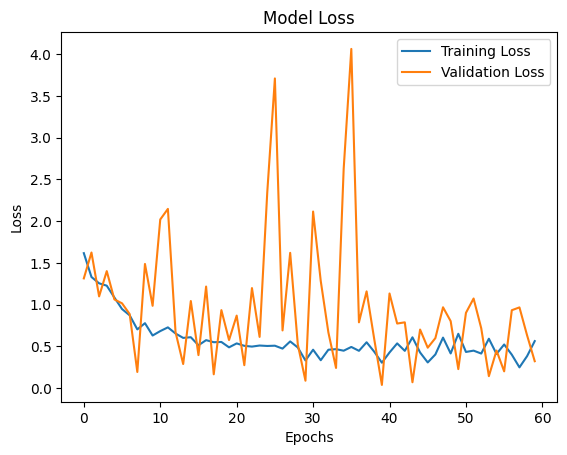

In [81]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
The predicted label is: meningioma
Prediction score for meningioma: 0.91


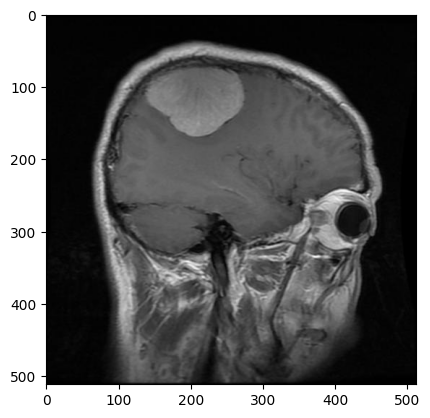

In [82]:
from tensorflow import keras

from tensorflow.keras.preprocessing import image

def predict_image(model, img_path, target_size=(64, 64)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize as trained

    prediction = model.predict(img_array)
    class_index = np.argmax(prediction, axis=1)[0]
    class_label = list(train_generator.class_indices.keys())[class_index]
    prediction_score = prediction[0][class_index]

    return class_label, prediction_score

# Predict a new image
img_path = keras.utils.load_img('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/meningioma/Te-me_0282.jpg')
plt.imshow(img_path)
img = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/meningioma/Te-me_0282.jpg'
predicted_label, prediction_score = predict_image(model, img)
print(f"The predicted label is: {predicted_label}")
print(f"Prediction score for {predicted_label}: {prediction_score:.2f}")

In [83]:
model_reduce_lr.save('model_reduce_lr.keras')